## Dataset: <a href='http://faculty.chicagobooth.edu/bernd.wittenbrink/cfd/index.html'>Chicago Face Database</a>
This is an alternative to the UTKFace dataset we've been using. It's much smaller, but it has a nice feature: a small group of gender/race labeled targets have 5 images, each making the same five faces (5 emotions including happy, scared, neutral). This gives us an alternative option to explore the race/gender bias of the VGGFace model.

### Question
VGGFace provides ID matches based on an embedding's nearest neighbor; in the paper, this distance is Euclidian distance (in practice, equivalent to cosine distance used in Identity). We can use the "closeness" of a group of embeddings for a particular target as a proxy for the model's matching performance on that target.

The question is: Does this "closeness" measure vary significantly across the binary sex class? Across the race classes?

### Data Preparation
In a seperate notebook, preprocessed the images by cropping/centering the faces and extracted the embeddings. I used methods/code from the Identity repository to do this. These embeddings are saved into .npy files and labeled by their filename.<br><br>
Here I'll just sort things out a bit with a pandas dataframe:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
from scipy.stats import ttest_ind

In [2]:
emb_path = '../../../cfd/embeddings/'
embeddings = [emb_path + name for name in os.listdir(emb_path)]
print(len(embeddings))

1207


In [3]:
df = pd.DataFrame(columns=['id', 'embedding', 'race', 'sex', 'exp'])
df['embedding'] = embeddings
len(df)

1207

In [4]:
races = dict()
races['A'] = 'asian'
races['B'] = 'black'
races['L'] = 'latino'
races['W'] = 'white'

def get_label(filename):
    """extracts label information from filename"""
    ext = filename.split(emb_path)[1]
    ext = ext.split('.npy')[0]
    return ext

def get_race(filename, races=races):
    """extracts race from filename"""
    ext = get_label(filename)
    lbl = ext.split('-')[1]
    race = races[lbl[0]]
    return race

def get_sex(filename):
    """extracts sex from filename"""
    ext = get_label(filename)
    lbl = ext.split('-')[1]
    sex = lbl[1]
    return sex

def get_id(filename):
    """extracts face id from filename"""
    ext = get_label(filename)
    splt = ext.split('-')
    id_ = splt[1] + '-' + splt[2]
    return id_

def get_exp(filename):
    """extracts expression label from filename"""
    ext = get_label(filename)
    exp = ext.split('-')[-1]
    return exp
    
df['id'] = df['embedding'].apply(get_id)
df['race'] = df['embedding'].apply(get_race)
df['sex'] = df['embedding'].apply(get_sex)
df['exp'] = df['embedding'].apply(get_exp)

In [5]:
def get_face(filename):
    path = filename.replace('embeddings', 'faces')
    img = np.load(path);
    return img

## Defining embedding "closeness"

For a given target, we can compute the embedding barycenter between the five embeddings. One measure of "closeness" is the mean distance from each embedding to the barycenter. Another is the maximum distance, a metric which may indicate that the model can make a mistake.

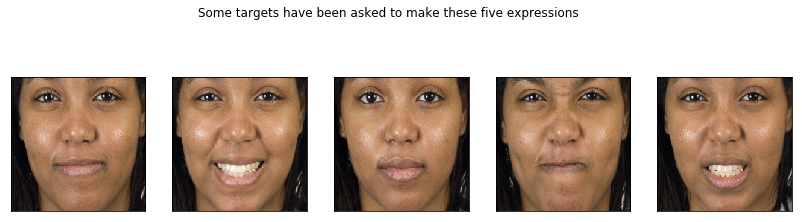

In [6]:
#These are the targets who have five images available.
multiples = list(df['id'].value_counts().loc[np.where(df['id'].value_counts() == 5, True, False)].index)
len(multiples)

fig, ax = plt.subplots(1, 5, figsize=(14, 4))
fig.suptitle('Some targets have been asked to make these five expressions')
cnt = 0
for i, row in df[df.id==multiples[-1]].iterrows():
    img = get_face(row.embedding)
    ax[cnt].imshow(img)
    ax[cnt].set_xticks([])
    ax[cnt].set_yticks([])
    cnt += 1

My goal is to define the "closeness" of these five embededings and look at how these distributions vary across gender/race classes.

In [7]:
def get_embedding(filename):
    array = np.load(filename)[0, 0, 0, :]
    array = np.expand_dims(array, axis=-1)
    return array

def get_mean_dist(df, target_id):
    """takes a target id and dataframe and returns the mean distance from the
    barycenter of all embeddings for that target.
    """
    embeddings = df[df['id']==target_id]['embedding'].apply(get_embedding).values
    as_array = np.concatenate(embeddings, axis=1)
    barycenter = as_array.mean(axis=1)
    distances = [np.linalg.norm(embed-barycenter) for embed in embeddings]
    mean = np.array(distances).mean()
    return mean

results = pd.DataFrame(columns=['id', 'mean_dist'])
results['id'] = multiples
results['mean_dist'] = results['id'].apply(lambda x: get_mean_dist(df, x))
results['sex'] = results['id'].apply(lambda x: x[1])
results['race'] = results['id'].apply(lambda x: races[x[0]])

In [8]:
def get_max_dist(df, target_id):
    """Get max dist between embedding and barycenter"""
    embeddings = df[df['id']==target_id]['embedding'].apply(get_embedding).values
    as_array = np.concatenate(embeddings, axis=1)
    barycenter = as_array.mean(axis=1)
    distances = [np.linalg.norm(embed-barycenter) for embed in embeddings]
    return max(distances)

results['max_dist'] = results['id'].apply(lambda x: get_max_dist(df, x))

## Same-Target Embedding Distribution Stats

Our two metrics, mean and max euclidian distance from barycenter have a population distribution that looks like this:

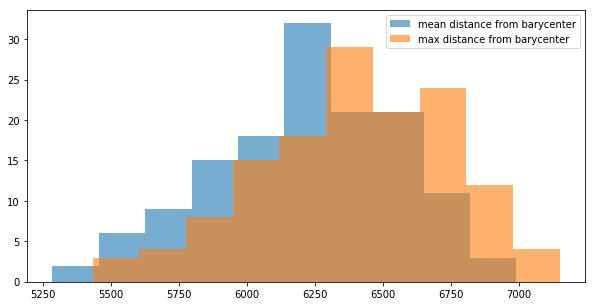

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(results.mean_dist, label='mean distance from barycenter', alpha=.6);
plt.hist(results.max_dist, label='max distance from barycenter', alpha=.6);
plt.legend();
plt.show();

We can see that these distributions are very approximately normal; given the small sample size (138), we might expect the underlying distributions to be normal for later assumptions (like the validity of student's t-test).

In [10]:
def plot_and_analyze(df, value, variable, intrst, cnd2=None, cat2=None, title='plot', var1_name=None, var2_name=None):
    """Generates a distribution plot and performs a t-test for significance.
    Value is the value in question, variable is the classification variable,
    intrst is the class that we are interested in.
    """
    if not var1_name:
        var1_name = 'exclusive population'
    if not var2_name:
        var2_name = intrst
    plt.figure(figsize=(10, 5))
    plt.title(title)
    pop1 = df[df[variable]!=intrst]
    if cnd2 != None:
        pop1 = pop1[pop1[cat2]==cnd2]
    exclusions = df.index.isin(pop1.index)
    pop2 = df[~exclusions]
    plt.hist(pop1[value], label=var1_name, density=True, alpha=.5);
    mean1 = pop1[value].mean()
    plt.axvline(x=mean1, linestyle='dotted', c='blue');
    plt.hist(pop2[value], label=var2_name, density=True, alpha=.5);
    mean2 = pop2[value].mean()
    plt.axvline(x=mean2, linestyle='dotted', c='red');
    plt.legend();
    plt.show();
    
    print('{} mean is: '.format(var2_name), round(mean2, 2))
    print('{} mean is: '.format(var1_name), round(mean1, 2))
    ttest_results = ttest_ind(pop1[value], pop2[value])
    print(ttest_results)
    return ttest_results


## Significant Splits

I split these distributions out into all possible subgroups, but only keep the splits where p < .05 in this notebook.

While the model tends to place female target's embeddings closer together on average than the males, a student's t-test indicates these apparent differences may be due to random variations in the results. More samples are needed to draw any meaningful conclusions here.

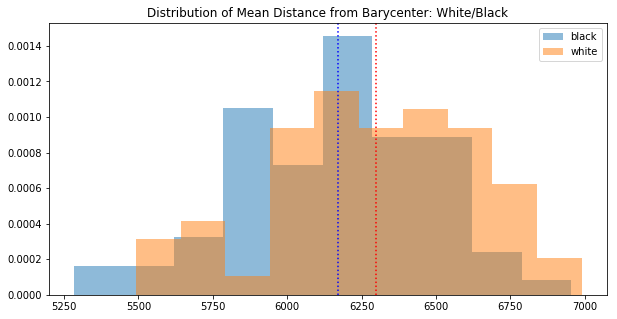

('white mean is: ', 6297.56)
('black mean is: ', 6171.23)
Ttest_indResult(statistic=-2.2077997365679063, pvalue=0.028933962770357168)


In [11]:
res3 = plot_and_analyze(
    results, 
    'mean_dist', 
    'race', 
    'white', 
    var1_name='black', 
    var2_name='white', 
    title='Distribution of Mean Distance from Barycenter: White/Black'
)

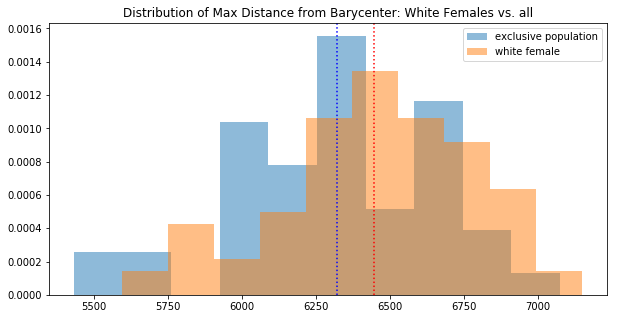

('white female mean is: ', 6447.73)
('exclusive population mean is: ', 6322.19)
Ttest_indResult(statistic=-2.041652651266528, pvalue=0.043119432922269975)


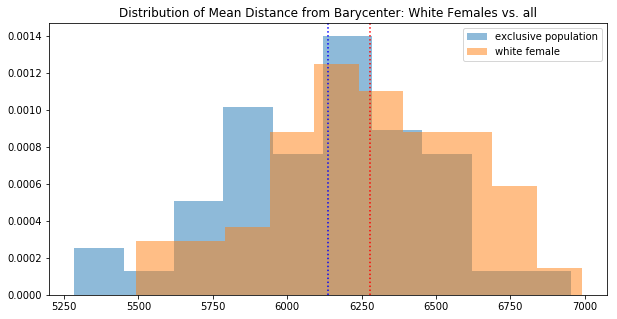

('white female mean is: ', 6278.43)
('exclusive population mean is: ', 6135.69)
Ttest_indResult(statistic=-2.377129856927714, pvalue=0.018840511066140698)


In [12]:
res5 = plot_and_analyze(
    results, 
    'max_dist', 
    'race', 
    'white',
    cat2='sex',
    cnd2='F',
    var2_name='white female', 
    title='Distribution of Max Distance from Barycenter: White Females vs. all'
)

res6 = plot_and_analyze(
    results, 
    'mean_dist', 
    'race', 
    'white',
    cat2='sex',
    cnd2='F',
    var2_name='white female', 
    title='Distribution of Mean Distance from Barycenter: White Females vs. all'
)

## Closeness Visualization
I use tsne to attempt to visualize the closeness of each of the individuals in this dataset. An interesting and unexpected result is the seperability of the race and sex subgroups. This effect is made more dramatic when we plot the images of the faces rather than colored points.

In [13]:
cols = [str(x) for x in range(2048)]
emb_df = pd.DataFrame(index=range(690), columns=cols+[])
j=0
for i, row in results.iterrows():
    id_ = row.id
    emb_files = df[df.id==id_].embedding
    embeddings = []
    for filename in emb_files:
        emb_df.loc[j, cols] = get_embedding(filename)[:, 0]
        emb_df.loc[j, 'id'] = row.id
        emb_df.loc[j, 'sex'] = row.sex
        emb_df.loc[j, 'race'] = row.race
        emb_df.loc[j, 'emb_path'] = filename
        j += 1

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE()
Y = tsne.fit_transform(emb_df[cols].values)

In [15]:
emb_df['tsne_a'] = Y[:, 0]
emb_df['tsne_b'] = Y[:, 1]

In [16]:
women = emb_df.index.isin(emb_df[emb_df.sex=='F'].index)
men = ~women

bf = emb_df.index.isin(emb_df[women][emb_df[women].race=='black'].index)
wf = emb_df.index.isin(emb_df[women][emb_df[women].race=='white'].index)
bm = emb_df.index.isin(emb_df[men][emb_df[men].race=='black'].index)
wm = emb_df.index.isin(emb_df[men][emb_df[men].race=='white'].index)

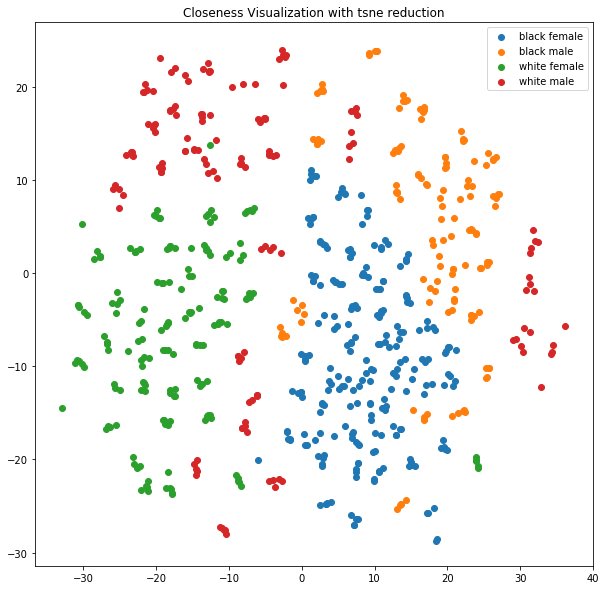

In [17]:
women = emb_df.index.isin(emb_df[emb_df.sex=='F'].index)
men = ~women

plt.figure(figsize=(10, 10))
plt.title('Closeness Visualization with tsne reduction')
plt.scatter(emb_df[bf].tsne_a, emb_df[bf].tsne_b, label='black female');
plt.scatter(emb_df[bm].tsne_a, emb_df[bm].tsne_b, label='black male');
plt.scatter(emb_df[wf].tsne_a, emb_df[wf].tsne_b, label='white female');
plt.scatter(emb_df[wm].tsne_a, emb_df[wm].tsne_b, label='white male');
plt.legend();

In [36]:
import tensorflow as tf

from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

LOG_DIR = 'vis_data'
varname = "face_embedding"
#total number of faces
TO_EMBED_COUNT = len(emb_df)
new_dim = 42

path_for_face_sprites =  os.path.join(LOG_DIR,'cfdfaces.png')
path_for_face_metadata =  os.path.join(LOG_DIR,'metadata.tsv')

batch_xs = emb_df[cols].values

In [37]:
batch_xs = emb_df[cols].values.astype(float)

embedding_var = tf.Variable(batch_xs, name=varname)
summary_writer = tf.summary.FileWriter(LOG_DIR)

In [38]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

embedding.metadata_path = path_for_face_metadata #'metadata.tsv'

# Specify where you find the sprite
embedding.sprite.image_path = path_for_face_sprites #'cfdfaces.png'
embedding.sprite.single_image_dim.extend([new_dim,new_dim,3])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

In [39]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

'vis_data/model.ckpt-1'

In [40]:
from skimage.transform import resize

def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots, 3))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def get_faces_images(df, resize_to=(new_dim,new_dim)):
    """Loads faces for each row in df. Resizes them and stacks
    them into ordered numpy array.
    """
    faces = []
    for i, row in df.iterrows():
        face = get_face(row.emb_path)
        face_resized = resize(face, resize_to, anti_aliasing=False)
        face = np.expand_dims(face_resized, axis=0)
        faces.append(face)
    result = np.concatenate(faces)
    return result
        
img_vec = get_faces_images(emb_df)
sprite_image = create_sprite_image(img_vec)
plt.imsave(path_for_face_sprites,sprite_image)

In [41]:
with open(path_for_face_metadata,'w') as f: #metadata.tsv
    f.write("Index\tLabel\n")
    for index,row in emb_df.iterrows():
        label=''
        if row.race=='black':
            label += 'b'
        elif row.race=='white':
            label += 'w'
        else:
            raise Exception('Unrecognized race: ', row.race)
        if row.sex=='F':
            label += 'f'
        elif row.sex=='M':
            label += 'm'
        else:
            raise Exception('Unrecognized sex: ', row.sex)
        f.write("%d\t%s\n" % (index,label))

In [42]:
#system calls to wrangle files and invoke tensorboard

os.system('rm -R vis_data/vis_data')
os.system('mkdir vis_data/vis_data')
os.system('cp vis_data/* vis_data/vis_data')

os.system('tensorboard -logdir={}'.format('vis_data'))

0

## T-sne Visualization with Faces
The following is a screenshot of the t-sne run by Tensorboard:

<img src="./imgs/tsne-face.png">

## Conclusion

Although the idea of this analysis was to compare the variance of same-identity embeddings with these facial expressions, a perhaps more interesting resuls is the way that the sex and race classes are represented in the embedding space. This initial should be further explored.